In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from datetime import datetime
sns.set()

# COVID19 Exploratory Data Analysis

# Table of contents
<a id='toc'></a>

## [Introduction](#intro)


## [Conclusion](#conclusion)

# Introduction <a id='intro'></a>

This notebook uses a variety of different COVID-19 related datasets to explore the behavior
of the multiple time series'. This notebook also creates new features that attempt to encapsulate the
time dependent (and time delayed) nature of the problem; these will be used during the model creation
project which makes time dependent forecasting models. 

There are a number of specific investigations that are relevant to the current situation as of July 7th 2020, even though data is only through June 30th.
The other category of investigations are regarding the data which will be used in the regression and neural network
models. 

### General COVID19 exploration

    10 countries with worst situations
    Exploration of the most important time series.
    Global stringency (government strictness) vs. cases
    Differences in government responses (early vs late)
    The relationship between the "reaction time" of government responses and death rate.
    The effect of last month's government strictness vs. the number of new cases today. 
    Current growth rates 


### Data quality exploration

    Differences between datasets.
    Inconsistencies and reporting errors in time series
    The effect of having a very small population

### Data quality exploration

    Differences between datasets.
    Inconsistencies and reporting errors in time series
    The effect of having a very small population
    
### Data quality exploration

    Differences between datasets.
    Inconsistencies and reporting errors in time series
    The effect of having a very small population



In [2]:
def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

    
def intersect_indexes(df1,df2,level=0):
    intersection = df1.index.get_level_values(level).intersection(df2.index.get_level_values(level))
    return df1.loc[intersection], df2.loc[intersection]


def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True,figsize=(4,4),xaxis='date'):
    data.set_index([xaxis, 'location']).loc[:, feature].unstack().plot(figsize=figsize, legend=legend)
    return None

def per_time_plot(data, feature, legend=True,figsize=(4,4),xaxis='time_index'):
    data.set_index(['location',xaxis]).loc[:, feature].unstack().plot(figsize=figsize, legend=legend)
    return None

def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        rollstd = None
        print(features, roll_widths)
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
                rollstd = df.loc[c, features].rolling(window).std().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
                rollstd = pd.concat((rollstd,  df.loc[c,features].rolling(window).std().fillna(value=0.)),axis=0)

        new_features = pd.concat((rollmean, rollstd), axis=1)
#         new_features = rollmean
#         new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         new_cols = mean_cols

        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list,axis=1)

def compare_ma_std_series(data, feature_names, location_list, scale=None, figname=None, xaxis='date'):   
    fig, ax = plt.subplots(figsize=(10,5))
    roll_mean_name, roll_std_name = feature_names

    roll_width = [char for char in roll_mean_name][-1]
    feature = roll_mean_name.split('_rolling')[0]
    data_plot = data.copy().set_index(xaxis)
    label_increment =(data.time_index.max()-data.time_index.min())//5
    for location in location_list:
        location_df = data_plot[data_plot.location==location]
        rollmean = location_df.loc[:, roll_mean_name].values
        rollstd = location_df.loc[:, roll_std_name].values
        lower = rollmean - rollstd
        lower[lower<0] = 0
        upper = rollmean + rollstd
        cis = (lower, upper)
        ax.fill_between(range(len(location_df)), cis[0], cis[1], alpha=0.1)
        ax.plot(range(len(location_df)), rollmean,
                        label=location)
        plt.title((feature+' {}-day MA +- {}-day STD ').format(roll_width,roll_width))
        _ = ax.set_ylabel(feature)
        _ = ax.set_xlabel(xaxis.capitalize())
        _ = ax.set_xticks(range(0,len(location_df),label_increment))
        if xaxis=='date':
            _ = ax.set_xticklabels(location_df.index[::label_increment].date)
        else:
            _ = ax.set_xticklabels(location_df.index[::label_increment])
        ax.grid(True)
    plt.legend(loc='upper left')
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
    if scale == 'log':
        ax.set_yscale('log')
    _ = plt.show()

    
    return None

def compare_time_series(data, feature, location_list, scale=None, figname=None,xaxis='date'):     
    fig, ax = plt.subplots(figsize=(10,5))
    data_plot = data.copy().set_index(xaxis)
    label_increment =(data.time_index.max()-data.time_index.min())//5
    for location in location_list:
        location_df = data_plot[(data_plot.location==location)]
        time_series = location_df.loc[:, feature]
        ax.plot(range(len(location_df)), time_series, label=location)
        plt.title(feature+' comparison')
        _ = ax.set_ylabel(feature)
        _ = ax.set_xlabel(xaxis.capitalize())
        _ = ax.set_xticks(range(0,len(location_df),label_increment))
        if xaxis=='date':
            _ = ax.set_xticklabels(location_df.index[::label_increment].date)
        else:
            _ = ax.set_xticklabels(location_df.index[::label_increment])
        ax.grid(True)
    if scale == 'log':
        ax.set_yscale('log')
    plt.legend(loc='upper left')
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
    _ = plt.show()

    return None
        

# Exploratory Data Analysis
<a id='EDA'></a>
[Return to table of contents](#toc)


In [3]:
data = pd.read_csv('data.csv', index_col=0)
data = data[data.location!='World']
data.loc[:,data.select_dtypes(include='number').columns] = data.select_dtypes(include='number').fillna(0)
data.loc[:, 'time_index'] += 1
data.loc[:, 'time_index'] = data.loc[:,'time_index'].astype(int)
data.loc[:, 'date'] = pd.to_datetime(data.date).dt.normalize().values

Although Italy had a similar number of cases per million as the United States (and earlier on, when less information on the disease was out), their reaction and subsequent actions quelled the pandemic. As can be seen, the United States did not control the pandemic enough, leading to a much smaller decrease followed by an increase in the number of cases per million.

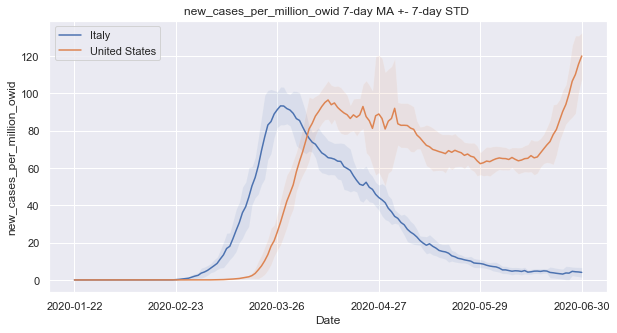

In [4]:
names = ('new_cases_per_million_owid_rolling_mean_7', 'new_cases_per_million_owid_rolling_std_7')
compare_ma_std_series(data, names, [ 'Italy','United States'], figname='ITA_vs_USA.jpg')


To analyze what was done differently, I look towards Oxford's stringency index, which quantifies the government strictness of each country. The Italian government was much more strict when their cases per million was peaking, which allowed for them to loosen restrictions sooner, once the pandemic was under control. I investigate later on the relation between this stringency index and other important quantities.

location
Italy            62.106894
United States    50.497640
dtype: float64


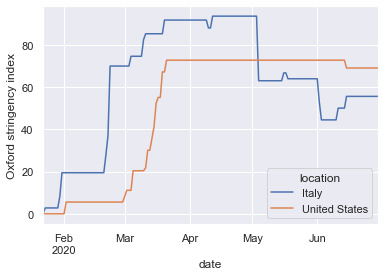

In [5]:
ITA_USA_stringency = data[data.location.isin( ['United States', 'Italy'])].set_index(['date','location']).stringency_index_oxcgrt.unstack()
ITA_USA_stringency.plot()
print(ITA_USA_stringency.mean())
_ = plt.ylabel('Oxford stringency index')
_ = plt.savefig('ITA_vs_USA_stringency.jpg', bbox_inches='tight')

To get an idea as to the spread of COVID-19, look at the distribution of the first recorded cases, deaths, and tests of all locations.

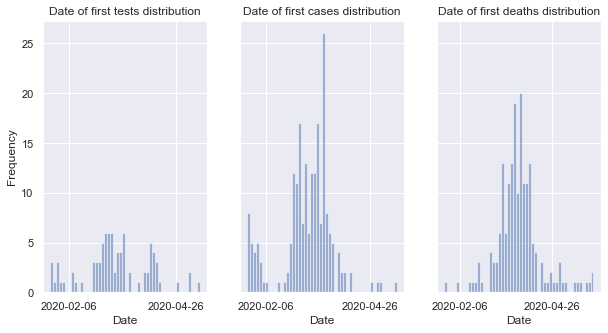

In [6]:
labelstart = 15
label_increment = (data.time_index.max() - data.time_index.min())//2

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5), sharey=True)
first_dates_temp = data.replace(to_replace=0., value=np.nan)
first_tests = data.loc[first_dates_temp.total_tests_owid.dropna().index,:].groupby('location').time_index.min()
first_cases =  data.loc[first_dates_temp.total_cases_owid.dropna().index,:].groupby('location').time_index.min()
first_deaths = data.loc[first_dates_temp.total_deaths_owid.dropna().index,:].groupby('location').time_index.min()
first_tests.plot.hist(alpha=0.5, bins=50, ax=ax1)
first_cases.plot.hist(alpha=0.5, bins=50, ax=ax2)
first_deaths.plot.hist(alpha=0.5, bins=50, ax=ax3)

_ = ax1.set_xlabel('Date')
_ = ax1.set_title('Date of first tests distribution')
_ = ax1.set_xticks(range(labelstart,data.time_index.max(),label_increment))
_ = ax1.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

_ = ax2.set_xlabel('Date')
_ = ax2.set_title('Date of first cases distribution')
_ = ax2.set_xticks(range(labelstart,data.time_index.max(),label_increment))
_ = ax2.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

_ = ax3.set_xlabel('Date')
_ = ax3.set_title('Date of first deaths distribution')
_ = ax3.set_xticks(range(labelstart, data.time_index.max(),label_increment))
_ = ax3.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])
plt.savefig('distribution_of_first_events.jpg', bbox_inches='tight')

An alternative manner of showing this is to plot the percentage of all countries which have been infected vs. time. 
In the modeling process, one thing that I believe may improve performance is to include the time indices for which most countries have cases, in the figure below this would be approximately the beginning of April 2020. Just an idea to keep in mind, as the beginning of each pandemic is unlike the period of time where it is full blown.

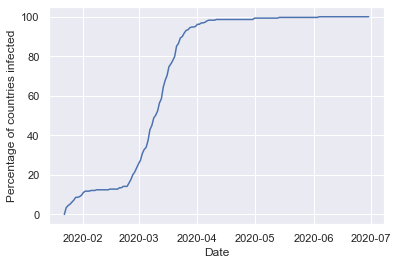

In [7]:
percentage_infected = []
for t in data.time_index.unique():
    percentage_infected.append(data[(data.time_index==t)&(data.days_since_first_case>=1)].location.nunique())
    
_ = plt.plot(data.date.unique(), 100*np.array(percentage_infected)/data.location.nunique())
_ = plt.ylabel('Percentage of countries infected')
_ = plt.xlabel('Date')
plt.savefig('percent_of_countries_with_cases.jpg', bbox_inches='tight')

For the modeling process, if I wanted to choose only dates for which all countries have had at least one case then I would have to go to 

The middle of the date range corresponds to the month of March, indicating that most countries experienced their first (recorded) cases around that month.

## Important time series and the countries which are (presumably) in the worst situations.

To get an idea as to the current severity of the global pandemic, look at the countries with highest numbers of cases and deaths, see if these countries are indeed testing sufficiently (i.e. the countries with highest tests would hopefully be the same). The following is an attempt to support my choices for which source to use for case and testing data. First, the testing data, the OWID dataset has a propensity to not have values for the most recent dates for testing. I.e. the new tests per million would be zero for the most recent days. Unsure why this is but I believe its a reporting issue and not an including the union of all dates issue. To get a feel for the current countries which are impacted the most, look at the most recent values for cases, tests, and deaths per million. One thing to note is that if a country has a high new case count and low testing, the situation may be far worse than it seems.

This exploration is also very important as the accuracy of these features is essential because they constitute the main time dependent features to be used in modeling. There is also redundancy in the data, so there is the benefit of being able to choose the "higher quality" features.

In [8]:
today = time_slice(data,-1,-1)
today.loc[:, ['location', 'total_cases_owid']].sort_values(by='total_cases_owid').dropna()[-10:]

,location,total_cases_owid
18836,Iran,225205.0
19802,Italy,240436.0
38639,Spain,249271.0
7727,Chile,275999.0
33004,Peru,282365.0
43147,United Kingdom,311965.0
18031,India,566840.0
34775,Russia,641156.0
5151,Brazil,1368195.0
43469,United States,2590552.0


In [9]:
today.loc[:, ['location', 'total_deaths_owid']].sort_values(by='total_deaths_owid').dropna()[-10:]

,location,total_deaths_owid
3702,Belgium,9752.0
18836,Iran,10670.0
18031,India,16893.0
25920,Mexico,27121.0
38639,Spain,28355.0
13684,France,29813.0
19802,Italy,34744.0
43147,United Kingdom,43575.0
5151,Brazil,58314.0
43469,United States,126140.0


In [10]:
top_10_locations_most_cases = today.set_index('location').new_cases_owid.dropna().sort_values()[-10:].index
top_10_locations_most_tests = today.set_index('location').new_tests_testtracker.dropna().sort_values()[-10:].index
top_10_locations_most_deaths = today.set_index('location').new_deaths_owid.dropna().sort_values()[-10:].index

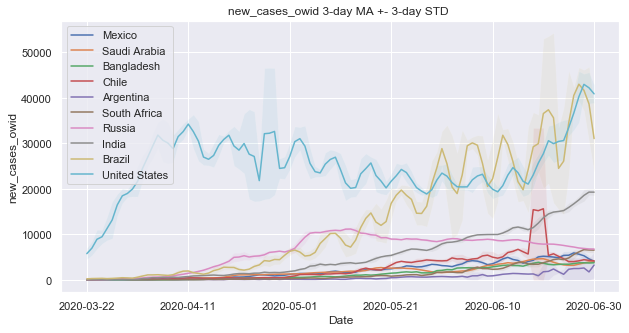

In [11]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_cases_owid_rolling_mean_3','new_cases_owid_rolling_std_3'), 
                      top_10_locations_most_cases,figname='top_10_new_cases.jpg')

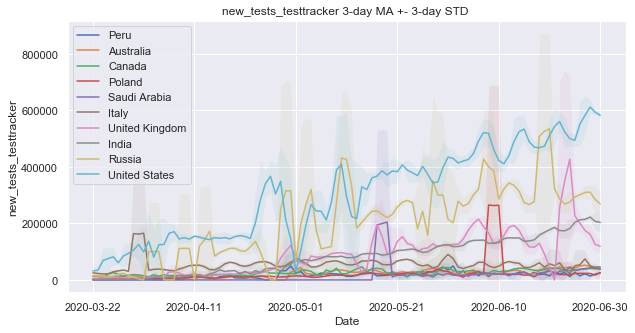

In [12]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_tests_testtracker_rolling_mean_3','new_tests_testtracker_rolling_std_3'), 
                      top_10_locations_most_tests)

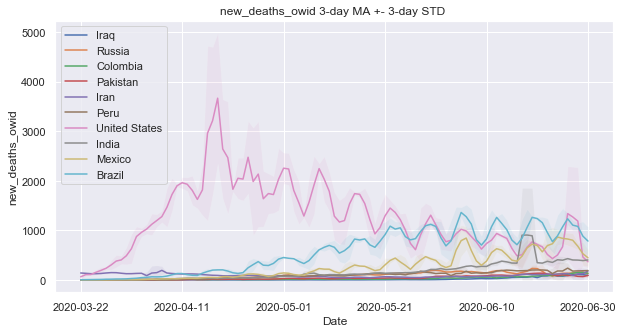

In [13]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_deaths_owid_rolling_mean_3','new_deaths_owid_rolling_std_3'), 
                      top_10_locations_most_deaths,figname='top_10_new_deaths.jpg')

The countries which are in the top 10 cases but are not in the top ten of tests are probably not testing enough; this should probably be calculated in another way, such as a case-test ratio. 

In [14]:
print('The countries which should likely test more are')
print(top_10_locations_most_cases[~top_10_locations_most_cases.isin(top_10_locations_most_tests)].tolist())

The countries which should likely test more are
['Mexico', 'Bangladesh', 'Chile', 'Argentina', 'South Africa', 'Brazil']


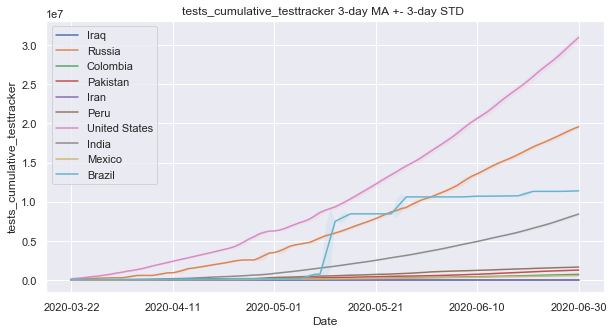

In [15]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('tests_cumulative_testtracker_rolling_mean_3','tests_cumulative_testtracker_rolling_std_3'), 
                      top_10_locations_most_deaths)

These regressions show that there is evidence for a statistically significant relationship between the average stringency and the approximate growth rates but not the maximum stringency. This makes sense, due to the time-delayed nature of the disease. I.e. if you're really strict but only for a single day/week then it wouldn't slow down the infection. 

# Data exploration specific to the United States.

The situation in the U.S. is quickly deteriorating, to the point where there needs to be more investigation into why this happened and the specifics for each state in order to forecast. Look at some time series plots for the states with the 10 most number of new cases.

In [39]:
# true y value.
print('True stringency average', x.loc['Italy'])
print('Effective stringency average',(y.loc['Italy']-intercept)/slope)
# predicted y value

True stringency average 66.57677419354843
Effective stringency average -43.11703717029857


In [40]:
# true y value.
print('True stringency average', x.loc['United States'])
print('Effective stringency average',(y.loc['United States']-intercept)/slope) 
# predicted y value

True stringency average 72.69000000000004
Effective stringency average 34.50373627488131


In [41]:
states = pd.read_csv('jhucsse_usa.csv').location.unique()
usa_data = data[data.location.isin(states.tolist())].set_index(['time_index','location'])
usa_data.loc[:, 'new_cases_jhucsse_usa'] = usa_data.groupby(level=1).cases_jhucsse_usa.diff(1).fillna(0).values
usa_data.loc[:, 'new_deaths_jhucsse_usa'] = usa_data.groupby(level=1).deaths_jhucsse_usa.diff(1).fillna(0).values
usa_data = usa_data.reset_index()

In [42]:
ten_states_with_most_new_cases = time_slice(usa_data,-1,-1).set_index('location').new_cases_jhucsse_usa.sort_values()[-10:].index

Because I decided to work with a separate dataset only using the states of the United States, need to recompute the moving averages

In [43]:
new_features = rolling_features(usa_data, ['new_cases_jhucsse_usa','new_deaths_jhucsse_usa'], [3])
usa_data = pd.concat((usa_data, new_features),axis=1)
# usa_data = usa_data.reset_index()

['new_cases_jhucsse_usa', 'new_deaths_jhucsse_usa'] [3]


In the past 40 days or so, the infections have spread dramatically in a few states. Check the trends of the 10 worst states by plotting rolling average.

In [44]:
feature_names = ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3')
location_list = ten_states_with_most_new_cases.tolist()

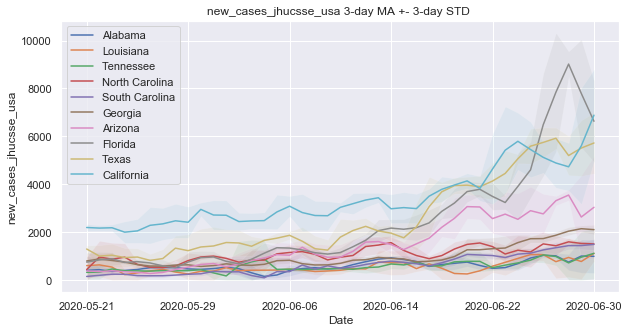

In [45]:
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3'), 
                      ten_states_with_most_new_cases.tolist(),figname='top_10_new_cases_america.jpg')


The number of cases seem to be increasing dramatically; this can have devastating consequences so let's also plot the deaths.

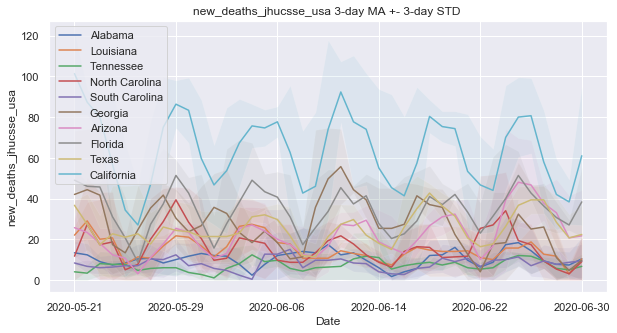

In [46]:
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      ('new_deaths_jhucsse_usa_rolling_mean_3','new_deaths_jhucsse_usa_rolling_std_3'), 
                      ten_states_with_most_new_cases.tolist(),figname='top_10_new_deaths_america.jpg')


At least the number of deaths seems to be maintaining the same, seasonal behavior. If I was unaware and I saw this I would assume that hospitals have not been overwhelmed yet, which is currently still the case. This would require looking at the hospitalization data. If hospitals are becoming overwhelmed then perhaps one explanation would be medical professionals are getting better at treating the illness.

## Differences data quality and or reporting

In order to know whether or not there is any funny business going on, I look at the main time series variables and their differences between data sets. First, I look at three different manners of computing the number of new cases per day (global sum). The blue and orange curves come from two separate data sets as is, and the 'total_cases_diff' curve is calculated by taking the 1-day finite difference of the cumulative cases variable, which itself is an average of all total cases variables in the data cleaning notebook.

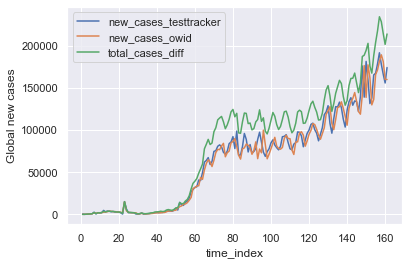

In [16]:
data.loc[:, column_search(data,'new_cases')[:2].tolist()+['location','time_index']].groupby('time_index').sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_cases.diff(1).fillna(0)
).plot(legend=True, label='total_cases_diff')
_ = plt.ylabel('Global new cases')
plt.savefig('cases_different_datasets.jpg', bbox_inches='tight')

In [17]:
def modify_time_series_zeros(df, features):
    df_modified = df.copy()
    df_modified.loc[:, features] = \
        (df_modified.loc[:, features].replace(to_replace=0., value=np.nan)
        ).groupby(df.location).fillna(method='ffill').fillna(value=0)
    return df_modified

Next is a demonstration as to why certain features had to be manipulated and have their values changed; strangeness in reporting. First, I'll demonstrate some peculiarity in the reporting of testing data.

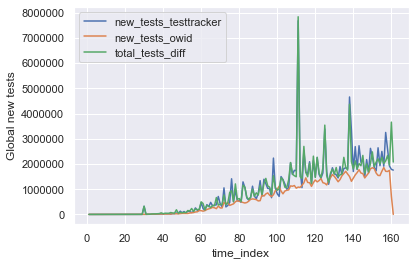

In [18]:
data.loc[:, column_search(data,'new_tests')[:2]].groupby(data.time_index).sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_tests.diff(1).fillna(0)
).plot(legend=True, label='total_tests_diff')
_ = plt.ylabel('Global new tests')
plt.savefig('tests_different_datasets.jpg', bbox_inches='tight')

For believed reporting reasons, the new tests from the OWID data are all zero for the most recent date. This is what the features look like once the time series have been modified.

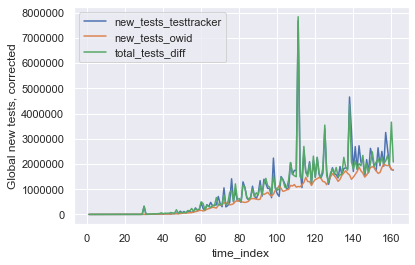

In [19]:
data = modify_time_series_zeros(data, 'new_tests_owid')
data.loc[:, column_search(data,'new_tests')[:2]].groupby(data.time_index).sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_tests.diff(1).fillna(0)
).plot(legend=True, label='total_tests_diff')
_ = plt.ylabel('Global new tests, corrected')
plt.savefig('tests_different_datasets_corrected.jpg', bbox_inches='tight')

The next figure is an exmple between the total deaths (which is the feature that I engineered which aggregated the different reports of deaths. By taking the total deaths and then the single day finite difference I can create a time series which is supposed to reproduce the original new deaths feature.

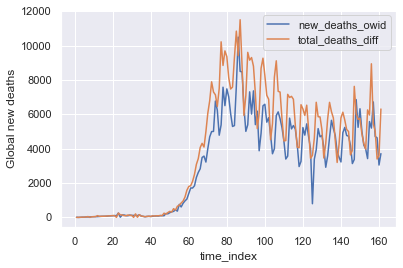

In [20]:
data.loc[:, column_search(data,'new_deaths')[:1].tolist()+['location','time_index']].groupby('time_index').sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_deaths.diff(1).fillna(0)
).plot(legend=True, label='total_deaths_diff')
_ = plt.ylabel('Global new deaths')
plt.savefig('deaths_different_datasets.jpg', bbox_inches='tight')

Next is the demonstration for my reasoning for why locations under 1 million in population are removed from the dataset.
The idea is that due to their small populations, the weighted quantity, new cases per million people, is unusually large in
magnitude. In fact, if I find the maximum for every country, and then plot the 20 countries with the largest maxima, this is what I get. 

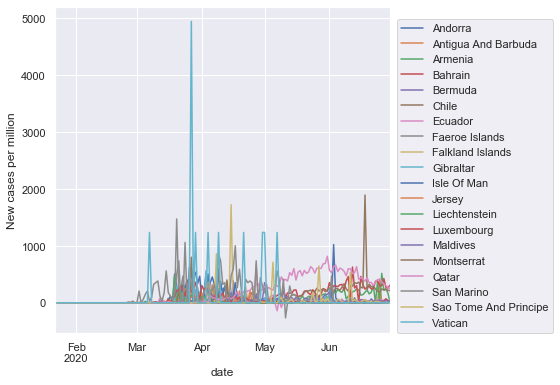

In [21]:
twentiest_largest_ncpm = data.groupby('location').max().new_cases_per_million_owid.sort_values()[-20:].index
per_country_plot(country_slice(data, twentiest_largest_ncpm), 'new_cases_per_million_owid', figsize=(6,6))
plt.ylabel('New cases per million')
plt.legend(loc=(1.02,0.))
plt.savefig('top_20_largest_new_cases.jpg', bbox_inches='tight')

In [22]:
print(('The countries with 20 largest new cases per million value account '
       'for only {} million people in the world').format(
    int(country_slice(data, twentiest_largest_ncpm).population_owid.unique().sum())//1000000))

The countries with 20 largest new cases per million value account for only 46 million people in the world


There is also an argument to be made to not use the testing data at all, largely because it is inconsistent in that
it contains a lot of reporting errors and is susceptible to very pathological time series; not only that, but also
the units for countries reporting testing differ. Some countries report the total number of tests completed while others
report the number of people tested. For instance, look at the difference in the time series for the 5 countries between different data sets.

In [23]:
data.tests_units_owid.value_counts()
testtmp0 = data[data.tests_units_owid=='people tested']
testtmp0loc = testtmp0.location.unique()[:5]

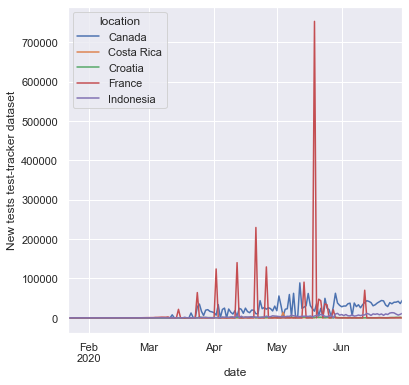

In [24]:
per_country_plot(country_slice(data, testtmp0loc), 'new_tests_testtracker',figsize=(6,6))
plt.ylabel('New tests test-tracker dataset')
plt.savefig('countrywise_testing_differences_0.jpg', bbox_inches='tight')

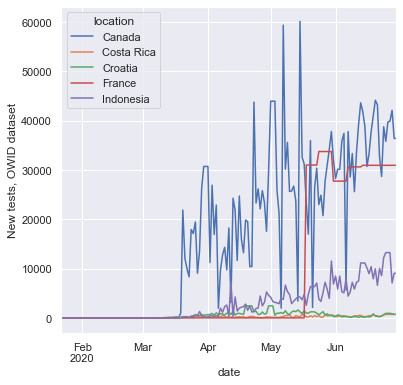

In [25]:
per_country_plot(country_slice(data, testtmp0loc), 'new_tests_owid', figsize=(6,6))
plt.ylabel('New tests, OWID dataset')
plt.savefig('countrywise_testing_differences_1.jpg', bbox_inches='tight')

The global state of COVID19 growth can be approximated by determining which countries have postive, flat, and negative growth rates.

In [50]:
two_months_ago = time_slice(data, -60, -30)
last_month = time_slice(data, -30, -1)

last_month_new_cases = (last_month[last_month.date == last_month.date.max()].total_cases.reset_index(drop=True) 
- last_month[last_month.date == last_month.date.min()].total_cases.reset_index(drop=True))

two_months_ago_new_cases = (two_months_ago[two_months_ago.date == two_months_ago.date.max()].total_cases.reset_index(drop=True) 
- two_months_ago[two_months_ago.date == two_months_ago.date.min()].total_cases.reset_index(drop=True))

# rate of change of new cases per month  
thirty_day_rate_of_change = last_month_new_cases - two_months_ago_new_cases
# round down small changes to 0. 
thirty_day_rate_of_change[np.abs(thirty_day_rate_of_change)<10] = 0

positive_growth = 100 * (thirty_day_rate_of_change > 0).sum() / len(thirty_day_rate_of_change)
negative_growth =100 * (thirty_day_rate_of_change < 0).sum() / len(thirty_day_rate_of_change)
stationary_growth = 100 * (thirty_day_rate_of_change==0).sum() / len(thirty_day_rate_of_change)
print('Today, %.2f percent of countries have a positive 30-day growth rate' % positive_growth)
print('Today, %.2f percent of countries have a negative 30-day growth rate' % negative_growth)
print('Today, %.2f percent of countries have approximately stationary 30-day growth rate' % stationary_growth)

Today, 53.63 percent of countries have a positive 30-day growth rate
Today, 29.76 percent of countries have a negative 30-day growth rate
Today, 16.61 percent of countries have approximately stationary 30-day growth rate


## The effect of government responses on the number of new cases.

To get a general idea for the state of the world right now, look at the levels of quarantine measures versus global average of new cases.  To investigate the effect of the stringency index on the future number of new cases (per million). I'm going to look at the monthly time scale; specifically I'm going to look at the relationship between the average (and max) stringency index and percentage increase (or decrease) between the average number of new cases two months ago and in the previous month. Yemen has some strange values so discard it for now.

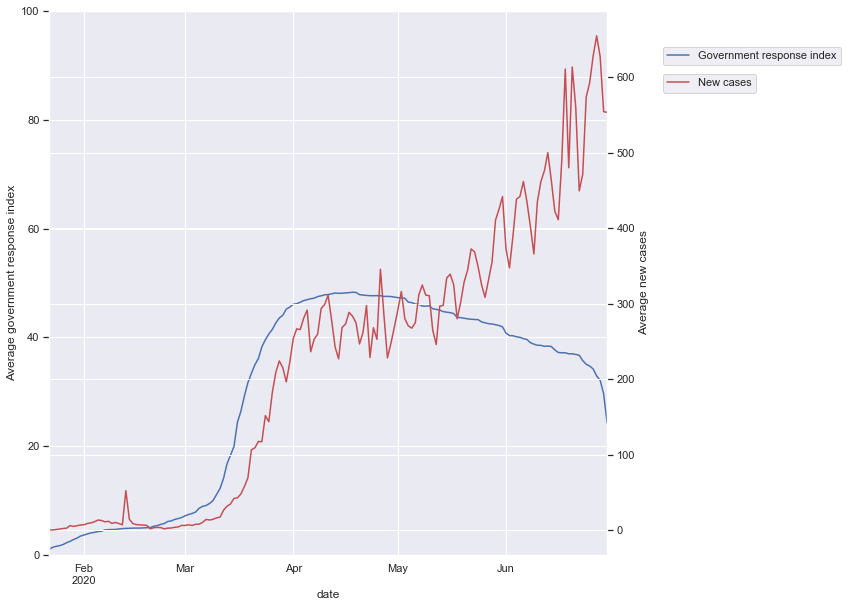

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax2 = ax.twinx()
data.groupby('date').mean().stringency_index_oxcgrt.plot(ax=ax, label='Government response index')
data.groupby('date').new_cases_owid.mean().plot(ax=ax2, color='r', label='New cases')
ax.set_ylim([0,100])
ax.set_ylabel('Average government response index')
ax2.set_ylabel('Average new cases')
ax.legend(loc=(1.1,0.9))
ax2.legend(loc=(1.1,0.85))
plt.savefig('global_average_stringency_vs_cases.jpg', bbox_inches='tight')

Note that the sharp downturn is partly due to errors in reporting, i.e. note the discontinuity at the most recent date for a couple countries.

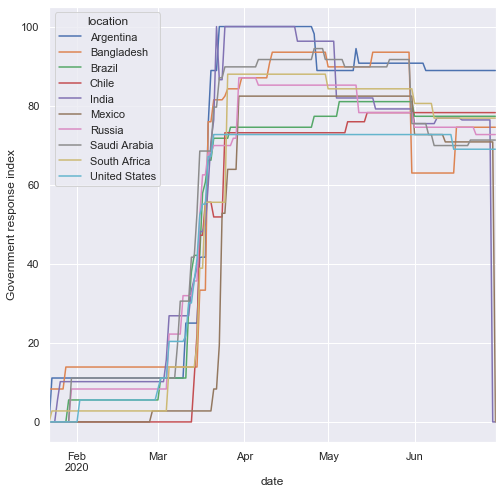

In [48]:
per_country_plot(data[data.location.isin(top_10_locations_most_cases)], 'stringency_index_oxcgrt', figsize=(5,5))
plt.ylabel('Government response index')
plt.savefig('stringency_top_10_countries.jpg', bbox_inches='tight')

In [26]:
locations_with_population_info = data.loc[data.population_owid.dropna().index,:]
locations_with_population_info.loc[:, 'total_cases_per_million'] = locations_with_population_info.total_cases / (locations_with_population_info.population_owid/1000000.)
locations_with_population_info = locations_with_population_info[locations_with_population_info.location!='Yemen']
locations_with_population_info = locations_with_population_info.set_index('location')

Compute the monthly (technically 30-day) averages of the number of new cases per million.

In [27]:
last_month_average_cpm = (time_slice(locations_with_population_info, -30, -1).new_cases_per_million_owid
               .replace(to_replace=np.inf,value=np.nan)
              ).dropna().groupby(level=0).mean().replace(to_replace=0., value=np.nan)

two_months_ago_average_cpm = (time_slice(locations_with_population_info, -60, -30).new_cases_per_million_owid
               .replace(to_replace=np.inf,value=np.nan)
              ).dropna().groupby(level=0).mean().replace(to_replace=0., value=np.nan)

In [28]:
one_months_total = (time_slice(locations_with_population_info, -30, -1).total_cases_per_million
               .replace(to_replace=np.inf,value=np.nan)
              ).dropna().groupby(level=0).mean().replace(to_replace=0., value=np.nan)

two_months_total = (time_slice(locations_with_population_info, -60, -30).total_cases_per_million
               .replace(to_replace=np.inf,value=np.nan)
              ).dropna().groupby(level=0).mean().replace(to_replace=0., value=np.nan)

need to normalize by how many cases there were initially, as widespread infection 

Find the average and maximum stringency index in next to last 30 days.

In [29]:
two_months_ago_stringency= time_slice(locations_with_population_info,-60,-30).stringency_index_oxcgrt
two_months_ago_max_stringency = two_months_ago_stringency.groupby(level=0).max()
two_months_ago_mean_stringency = two_months_ago_stringency.groupby(level=0).mean()

Take only the countries which have non-zero stringency values (data set countries USA states, OxCGRT stringency index does not report these locations).

If there is growth, then let that be positive, i.e. let last month > two months be positive.

In [30]:
growth_factors = (last_month_average_cpm/two_months_ago_average_cpm)

In [31]:
locations_with_stringency_data = two_months_ago_max_stringency.replace(to_replace=0., value=np.nan).dropna().index
location_intersection = growth_factors.index.intersection(locations_with_stringency_data)

My claim is that the number of new cases per million affects the next month stringency, which affects next month change in cases. Look at the multiplicative growth factor because absolute number of new cases will depend on how many cases total. 

0.6617804701122998


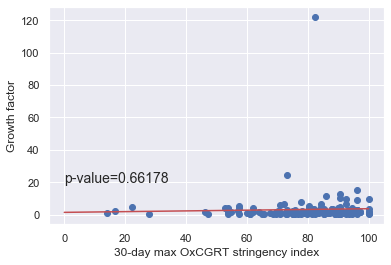

In [32]:
x = two_months_ago_max_stringency.loc[location_intersection]
y = growth_factors

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.grid(True)
print(p_value)
plt.ylabel('Growth factor')
plt.xlabel('30-day max OxCGRT stringency index')
plt.text(0.0, 20,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('growth_factors_vs_max_stringency.jpg', bbox_inches='tight')

0.5442850362293205


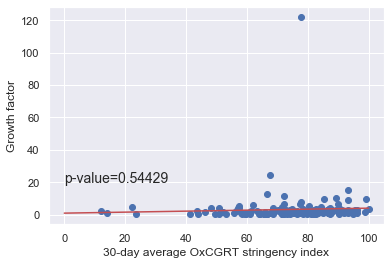

In [33]:
x = two_months_ago_mean_stringency.loc[location_intersection]
y = growth_factors

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.grid(True)
print(p_value)
plt.ylabel('Growth factor')
plt.xlabel('30-day average OxCGRT stringency index')
plt.text(0.0, 20,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('growth_factors_vs_mean_stringency.jpg', bbox_inches='tight')

The values are tightly distributed around 0, there is no statistical relationship between the original data, so in addition perform a logarithmic transformation (log(x+1)) on the new_cases_per_million_growth_factors. 

0.23337253349533557


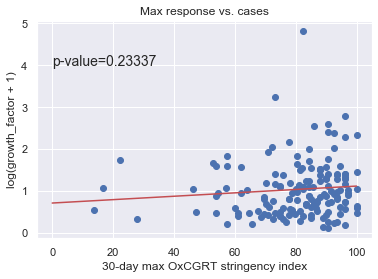

In [34]:
x = two_months_ago_max_stringency.loc[location_intersection]
y = np.log(growth_factors+1)

x, y =   intersect_indexes(x.dropna(), y.dropna(),level=0)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.set_title('Max response vs. cases')
ax.grid(True)
print(p_value)
plt.ylabel('log(growth_factor + 1)')
plt.xlabel('30-day max OxCGRT stringency index')
plt.text(0.0, 4,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('log_growth_factors_vs_max_stringency.jpg', bbox_inches='tight')

How can the discrepancy between the effective stringency and the real stringency be explained? I think it is intuitive to assume that this is due to the differences between states, as the majority of cases are coming from a few super spreading states.

In [35]:
x = two_months_ago_mean_stringency.loc[location_intersection]
y = np.log(growth_factors+1)

0.045072262549047955


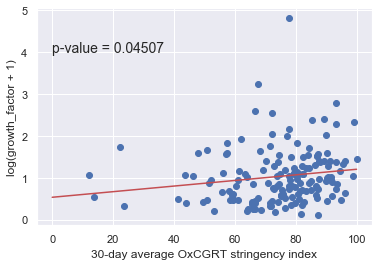

In [38]:
x, y =   intersect_indexes(x.dropna(), y.dropna(), level=0)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x , y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.grid(True)
print(p_value)
plt.ylabel('log(growth_factor + 1)')
plt.xlabel('30-day average OxCGRT stringency index')
plt.text(0,4, 'p-value = '+str(np.round(p_value,5)),fontsize=14)
plt.savefig('log_growth_factors_vs_mean_stringency.jpg', bbox_inches='tight')

Like the new tests from owid, both sources of stringency values have believed errors in reporting the most recent dates as 0's and so the sharp downturn at the right side of the plot of the stringency shouldn't be taken seriously, note the unlikely 0's at the end for Mexico and India in the next plot.

The stringency index is a quantification of the following measures. As there are only 8 entries this is likely not
an exhaustive list, but rather the most common measures taken.

In [49]:
[' '.join(x.split('_')[1:]) for x in pd.read_csv('oxcgrt.csv').iloc[:, 4:20:2].columns.tolist()]

['school closing',
 'workplace closing',
 'cancel public events',
 'restrictions on gatherings',
 'close public transport',
 'stay at home requirements',
 'restrictions on internal movement',
 'international travel controls']

Summary statistics of the "age" of the pandemic in each country.

In [51]:
print('The statistics of the age of the pandemic in each country, in units of days.\n')
print(today.days_since_first_case.describe())

The statistics of the age of the pandemic in each country, in units of days.

count    289.000000
mean     115.564014
std       19.247390
min       27.000000
25%      105.000000
50%      113.000000
75%      122.000000
max      160.000000
Name: days_since_first_case, dtype: float64


## Government mandates, reaction times and their effects.

The next segment of exploration is into the statistical significance of different quarantine measures on the number of new cases. This is a crude approximation and likely should not be treated as an official result. First, however, let's explore the timelines and values of different governments' reactions. The first step is to collect all of the reactions into a dataframe.

In [195]:
government_responses = pd.concat((data.loc[:, ['location','time_index','days_since_first_case']],
                                  data.loc[:, column_search(data, 'oxcgrt')].drop(
                                      columns=column_search(data, 'flag')).iloc[:,2:10]), axis=1)

Find the countries which eventually have all responses by a conditional statement which counts if a country only
has 0 as a value for any specific measure. In other words, if the value for a mandate is always 0, that means it was never
enacted. 

In [196]:
countries_with_responses = government_responses.groupby('location').max().dropna()
countries_with_all_responses = (countries_with_responses.iloc[np.where((
    government_responses.groupby('location').max().dropna()==0).sum(1)==0)[0],:])


In [221]:
tmptmp = (government_responses[~government_responses.isin(states)].groupby('location').max()==0).sum(axis=1)
government_responses_all = government_responses[government_responses.location.isin(tmptmp.index[tmptmp==0])].set_index('location')

With the list of applicable countries, can now begin to acquire the dates on which each mandate started (and ended).

In [238]:
# responses = pd.Index(['active_pandemic_dates']).append(countries_with_all_responses.columns[2:])
responses = pd.Index(['active_pandemic_dates']).append(government_responses_all.columns[2:])

In [240]:
# all_responses = government_responses[government_responses.location.isin(countries_with_all_responses.index)]
all_responses = government_responses_all.reset_index()
response_ranges = []
for c in all_responses.columns[2:]:
    active_range = all_responses.loc[:, ['time_index','location']+[c]].replace(to_replace=[0,0.], value=np.nan).dropna().groupby('location').time_index
    response_ranges.append([slice(*x) for x in list(zip(active_range.min().values, active_range.max().values+1))])
    

In [247]:
response_slices_df = pd.DataFrame(np.array(response_ranges).transpose(),
                                 index=all_responses.location.unique(), columns=responses)

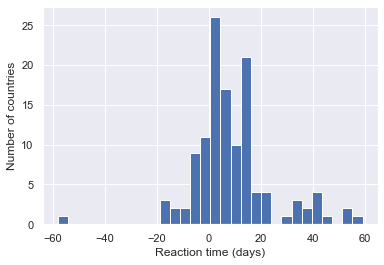

In [248]:
average_response_date = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].mean(1)
average_reaction_times = (average_response_date.astype(int) 
                          - response_slices_df.applymap(lambda x : x.start).active_pandemic_dates)
_ = plt.hist(average_reaction_times, bins=30)
_ = plt.ylabel('Number of countries')
_ = plt.xlabel('Reaction time (days)')
plt.savefig('average_reaction_times_distribution.jpg', bbox_inches='tight')

The next plot demonstrates the average "reaction time" as quantified by the average date of all mandates, compared to the date of first case. 

A question to be answered, do these average reaction times have a quantifiable effect on serious quantities such as death rate? To investigate, configure the data to be used in regression.

In [58]:
death_rates = today.total_deaths / today.total_cases
death_rates.index = today.location.values
death_rates = death_rates.dropna()
average_reaction_times = average_reaction_times.dropna()

In [59]:
countries_with_all_average_reaction = average_reaction_times.index.intersection(death_rates.index)
death_rates = 100*death_rates.loc[countries_with_all_average_reaction]
average_reaction_times = average_reaction_times.loc[countries_with_all_average_reaction]

In [60]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(average_reaction_times.values, death_rates.values)

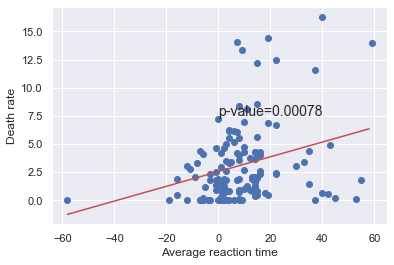

In [61]:
fig, ax = plt.subplots()
ax.scatter(average_reaction_times, 
            death_rates)
ax.plot(np.arange(average_reaction_times.values.min(),average_reaction_times.values.max()),
        slope*np.arange(average_reaction_times.values.min(),average_reaction_times.values.max()) + intercept, color='r')
# ax.set_ylim([-4, 4])
# ax.set_xlim([-4, 4])
ax.grid(True)
plt.ylabel('Death rate')
plt.xlabel('Average reaction time')
plt.text(0.0, 7.5,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('death_rates_vs_average_reaction_time.jpg', bbox_inches='tight')

In [62]:
date_of_first_response = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].min(1)
date_of_pandemic_start =  response_slices_df.applymap(lambda x : x.start).active_pandemic_dates
minimum_reaction_times = (date_of_first_response-date_of_pandemic_start)


Early responders, first government action BEFORE first case.

In [63]:
early_responders = average_reaction_times[average_reaction_times<0].index.tolist()
print('\n The early responders:\n')
for i in range(len(early_responders)//5+1):
    print(early_responders[5*i:5*(i+1)])


 The early responders:

['Albania', 'Angola', 'Botswana', 'El Salvador', 'Eswatini']
['Fiji', 'Greenland', 'Guatemala', 'Haiti', 'Kenya']
['Kosovo', 'Kyrgyz Republic', 'Laos', 'Lesotho', 'Libya']
['Madagascar', 'Mongolia', 'Myanmar', 'Papua New Guinea', 'Puerto Rico']
['Rwanda', 'Sierra Leone', 'South Sudan', 'Syria', 'Uganda']
['Zimbabwe']


Late responders, first government action AFTER first case.


In [64]:
late_responders = average_reaction_times[average_reaction_times>=0].index.tolist()
print('The late responders:\n')
for i in range(len(late_responders)//5+1):
    print(late_responders[5*i:5*(i+1)])

The late responders:

['Afghanistan', 'Algeria', 'Argentina', 'Austria', 'Azerbaijan']
['Bahrain', 'Bangladesh', 'Barbados', 'Belize', 'Bermuda']
['Bhutan', 'Bolivia', 'Bosnia And Herzegovina', 'Brazil', 'Burkina Faso']
['Cape Verde', 'Chad', 'China', 'Colombia', 'Congo']
['Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Democratic Republic Of Congo']
['Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt']
['Eritrea', 'Ethiopia', 'France', 'Gabon', 'Gambia']
['Georgia', 'Ghana', 'Greece', 'Guinea Bissau', 'Guyana']
['Honduras', 'Hungary', 'India', 'Indonesia', 'Iraq']
['Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica']
['Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Liberia']
['Lithuania', 'Mauritius', 'Mexico', 'Moldova', 'Morocco']
['Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria']
['Oman', 'Pakistan', 'Palestine', 'Panama', 'Paraguay']
['Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar']
['Romania', 'Russia', 'San Marino', 'Saudi Arabia', 'Serbia']
['Seychel

In [65]:
late_data = data[data.location.isin(late_responders)]
early_data = data[data.location.isin(early_responders)]

early_data_present_day = early_data[early_data.time_index == data.time_index.max()]
late_data_present_day = late_data[late_data.time_index == data.time_index.max()]

d_rate = pd.Series(death_rates, index=data.location.unique())
early_d_rates = d_rate.loc[early_data_present_day.location.unique()]
late_d_rates = d_rate.loc[late_data_present_day.location.unique()]

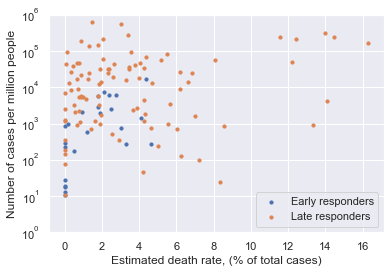

In [66]:
_ = plt.scatter(early_d_rates, early_data_present_day.total_cases_owid.values, label='Early responders',s=10)
_ = plt.scatter(late_d_rates, late_data_present_day.total_cases_owid.values, label='Late responders',s=10)
_ = plt.xlabel('Estimated death rate, (% of total cases)')
_ = plt.ylabel('Number of cases per million people')
_ = plt.yscale('log')
_ = plt.ylim([1, 1000000])
_ = plt.legend()
plt.savefig('early_vs_late_responder_death_rates.jpg', bbox_inches='tight')

## Testing the importance of different quarantine measures with two-way ANOVA  <a id='ANOVA2'></a>

With the world currently under maintenance and public sentiment deteriorating, it is important to identify
the most efficient quarantine measures so that governments know how to be proactive going forward.
Given a set of countries how do specific quarantine measures affect the growth rate of COVID-19? To analyze this, we used the strictly increasing quantity of total number of tests per capita. Th main external factor which was not taken into account is the fact that the more tests a country performs the more cases typically emerge; i.e., the rate over time
may increase as a result of increased testing and not spread of the disease itself.

To test this relation, I will first create a numerical measure whose goal is to quantify the effect of each quarantine measure.
This feature is the difference between the 30 day averages of the number of new cases per million people. That is,
compute the dates at which each mandate occurs, calculate the average number of cases per million people in the 30 days before and after this date. Take the difference to approximate a growth rate in the number of new cases.

This requires a few steps:

    1. Remove countries who did not enact all mandates (i.e. have missing values).
    2. Find the dates on which each mandate started.
    3. Find the +- 30 day averages and take the difference.
    4. Format the data in a way to be compatible with statsmodels api.
    5. Look at the p-values for the blocks (countries) and treatments (mandates).
    
The data preprocessing such as taking the correct subset of all countries and dates has already been performed in
the data cleaning notebook. 
    
This type of analysis has a number of requirements involving the distribution of values as well as the variances
of each treatment, but for now I'll assume they are satisfied.

Two-way ANOVA: Factor A will be quarantine type? Factor B is Country? Only count countries where
quarantine has been active for 2 weeks consectutively. The trials will be the time series. (weighted by population, and number of tests).

0. determine which government responses to use, based on how widespread their adoption was. 
['c1_school_closing',
 'c2_workplace_closing',
 'c3_cancel_public_events',
 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',
 'c6_stay_at_home_requirements',
 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']

The reason why I average over 30 day intervals is to reduce the effect of any outliers and smooth out any erratic reporting behavior. Additionally, there is a (the specifics are still unknown) time-delay component to the spread of the infection. 

By iterating over the countries and government responses, equation (\ref{eq:avgrates}) produces a table of observations on which two-way ANOVA can be applied. Specifically,
the blocks were taken to be the different quarantine measures and the treatments were taken to be the countries. The confidence level is chosen to be 95\% and the corresponding hypothesis set can be written as
\begin{align}
    H_0 &: \mu_0 = \mu_1 = ... = \mu_a \nonumber\\
    H_1 &: \text{any of the means is different} \nonumber
\end{align}

First, create a dataframe with the government responses and time indices.

For other reasons create a separate dataframe for the starting and ending dates.

In [319]:
start_dates = response_slices_df.applymap(lambda x : x.start)
stop_dates = response_slices_df.applymap(lambda x : x.stop)
start_dates.columns =[x[0] for x in response_slices_df.columns.str.split('_oxcgrt')]

Because I want to compute 30-day averages, drop the data/countries which started less than 30 months into the dataset.
Even if these countries were kept somehow, there would not be data to compute the growth rates with.

In [320]:
# first_event = start_dates.transpose().idxmin()
# pandemic_first_countries = first_event[first_event=='active_pandemic_dates'].index
# start_dates = start_dates[start_dates.index.isin(pandemic_first_countries)]

In [321]:
# start_dates[start_dates<29]=np.nan
start_dates = start_dates.dropna().astype(int).iloc[:,1:]
start_dates

,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls
Afghanistan,53,63,40,75,67,64,64,33
Albania,48,50,48,48,52,52,52,35
Algeria,51,62,49,69,62,62,62,51
Angola,63,66,66,63,66,66,66,16
Argentina,55,58,50,58,62,58,59,50
...,...,...,...,...,...,...,...,...
United States,44,58,40,50,56,54,53,12
Uzbekistan,55,55,55,62,55,66,63,40
Venezuela,55,55,51,51,133,52,52,51
Vietnam,8,64,18,65,67,71,23,4


In [361]:
pre_action_dates = start_dates - 30
pre_action_dates[pre_action_dates<0] = 0
post_action_dates = start_dates+30

Collect the time indices for the 30 days before and after, to use for slicing of the data.

In [362]:
 (pre_action_dates.applymap(lambda x : [x]) + start_dates.applymap(lambda x : [x]))

,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls
Afghanistan,"[23, 53]","[33, 63]","[10, 40]","[45, 75]","[37, 67]","[34, 64]","[34, 64]","[3, 33]"
Albania,"[18, 48]","[20, 50]","[18, 48]","[18, 48]","[22, 52]","[22, 52]","[22, 52]","[5, 35]"
Algeria,"[21, 51]","[32, 62]","[19, 49]","[39, 69]","[32, 62]","[32, 62]","[32, 62]","[21, 51]"
Angola,"[33, 63]","[36, 66]","[36, 66]","[33, 63]","[36, 66]","[36, 66]","[36, 66]","[0, 16]"
Argentina,"[25, 55]","[28, 58]","[20, 50]","[28, 58]","[32, 62]","[28, 58]","[29, 59]","[20, 50]"
...,...,...,...,...,...,...,...,...
United States,"[14, 44]","[28, 58]","[10, 40]","[20, 50]","[26, 56]","[24, 54]","[23, 53]","[0, 12]"
Uzbekistan,"[25, 55]","[25, 55]","[25, 55]","[32, 62]","[25, 55]","[36, 66]","[33, 63]","[10, 40]"
Venezuela,"[25, 55]","[25, 55]","[21, 51]","[21, 51]","[103, 133]","[22, 52]","[22, 52]","[21, 51]"
Vietnam,"[0, 8]","[34, 64]","[0, 18]","[35, 65]","[37, 67]","[41, 71]","[0, 23]","[0, 4]"


In [363]:
time_index_before = (pre_action_dates.applymap(lambda x : [x]) + start_dates.applymap(lambda x : [x])).applymap(lambda x : list(range(*tuple(x))))

In [364]:
time_index_after = (start_dates.applymap(lambda x : [x+1])+post_action_dates.applymap(lambda x : [x+1])).applymap(lambda x : list(range(*tuple(x))))

Combine these time indices with their corresponding country so that the pair of data can be used for slicing.

In [365]:
after = time_index_after.stack()
location_timeindex_after =  np.array(list(zip(after.index.get_level_values(0), after.values)))

before = time_index_before.stack()
location_timeindex_before =  np.array(list(zip(before.index.get_level_values(0), before.values)))

current = start_dates.applymap(lambda x : [x]).stack()
location_timeindex_current = np.array(list(zip(before.index.get_level_values(0), current.values)))

Slice out the current, before and after values.

In [366]:
before_averages = []
after_averages = []
current_values = []
for i in range(len(location_timeindex_before)):
    before_averages.append(data[(data.location==location_timeindex_after[i,0])&
         (data.time_index.isin(location_timeindex_after[i,1]))].new_cases_per_million_owid.mean())
    after_averages.append(data[(data.location==location_timeindex_before[i,0])&
         (data.time_index.isin(location_timeindex_before[i,1]))].new_cases_per_million_owid.mean())
    current_values.append(data[(data.location==location_timeindex_current[i,0])&
         (data.time_index.isin(location_timeindex_current[i,1]))].new_cases_per_million_owid.mean())

Compute the approximate growth rates, elect to do ratio of averages, as in the stringency analysis. divided 

In [498]:
before_current_after = pd.DataFrame(np.array([before_averages, current_values, after_averages]).transpose(),
                                    index=time_index_before.stack().index, columns=['before','current', 'after'])
before_after = (before_current_after.before/before_current_after.after)
before_after = before_after.unstack().replace(to_replace=np.inf, value=np.nan).dropna().stack()


Perform ANOVA analysis using statsmodels api. In order to handle missing values, need to do the ratio of before / after, instead of after / before. The reason for this is because if I do before / after, then a *larger* value will indicate a greater decrease. This cannot be done for the reciprocal, because I would then have to assign a value of infinity to missing values instead of zero. 

In [501]:
anova_df = before_after.reset_index()
anova_df.columns = ['Country', 'Type', 'Change']

import statsmodels.api as sm

formula = 'Change ~ Type + Country'
model = sm.formula.ols(formula, data=anova_df).fit()

# Perform ANOVA and print table
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                sum_sq     df          F        PR(>F)
Type      2.151853e+06    7.0   4.319966  1.626361e-04
Country   2.441655e+07   33.0  10.397672  4.191254e-30
Residual  1.643790e+07  231.0        NaN           NaN


This provides evidence that there are definitely differences between countries (which is believable but also somewhat obvious); the p-value for type also indicates a relationship, but to validate these results I need to look at the data. The variances are approximately the same.

In [502]:
government_responses_labels =['school closing',
 'workplace closing',
 'cancel public events',
 'restrictions on gatherings',
 'close public transport',
 'stay at home requirements',
 'restrictions on internal movement',
 'international travel controls']

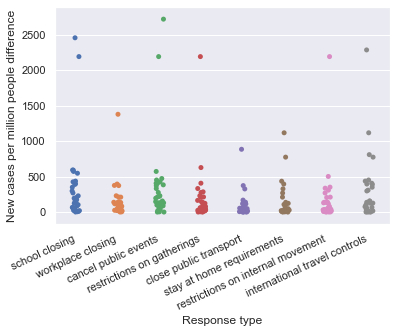

In [503]:
sptmp = before_after.reset_index(level=1)
sptmp.columns = ['Response type', 'residual']
ax = sns.stripplot(data=sptmp, x='Response type', y='residual')
plt.xticks(rotation=25)
loc, _ = plt.xticks()
plt.xticks([0,1,2,3,4,5,6,7], government_responses_labels,ha='right')
plt.ylabel('New cases per million people difference')
plt.savefig('anova_variance.jpg', bbox_inches='tight')

The residuals also seem like they could be normally distributed.

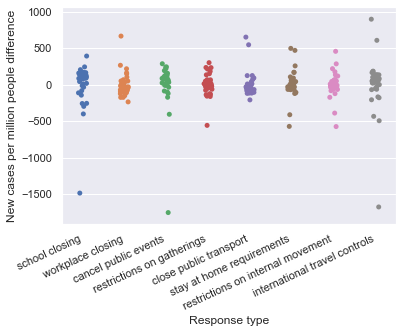

In [504]:
residual_df = (pd.DataFrame(model.predict().reshape(before_after.unstack().shape)
                            -before_after.values.reshape(before_after.unstack().shape)))
residual_df.columns = before_after.unstack().columns
residual_df.index = before_after.unstack().index
residual_df= residual_df.stack().reset_index(level=1)
residual_df.columns = ['Response type', 'residual']

ax = sns.stripplot(data=residual_df, x='Response type', y='residual')
plt.xticks(rotation=25)
loc, _ = plt.xticks()
plt.xticks([0,1,2,3,4,5,6,7], government_responses_labels,ha='right')
plt.ylabel('New cases per million people difference')
plt.savefig('anova_variance.jpg', bbox_inches='tight')

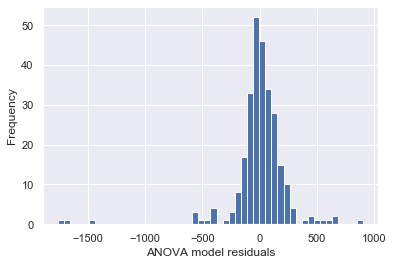

In [505]:
anova_model_residuals = model.predict() - before_after.values
_ = plt.hist(anova_model_residuals, bins=50)
_ = plt.ylabel('Frequency')
_ = plt.xlabel('ANOVA model residuals')

plt.savefig('anova_residuals.jpg', bbox_inches='tight')

The main issue with reaching a conclusion is then the fact that these mandates are not independent from one another; many are adopted on the same date. Regardless, I go forward with a crude analysis as to which responses are the most effective. 

For a visual comparison between 

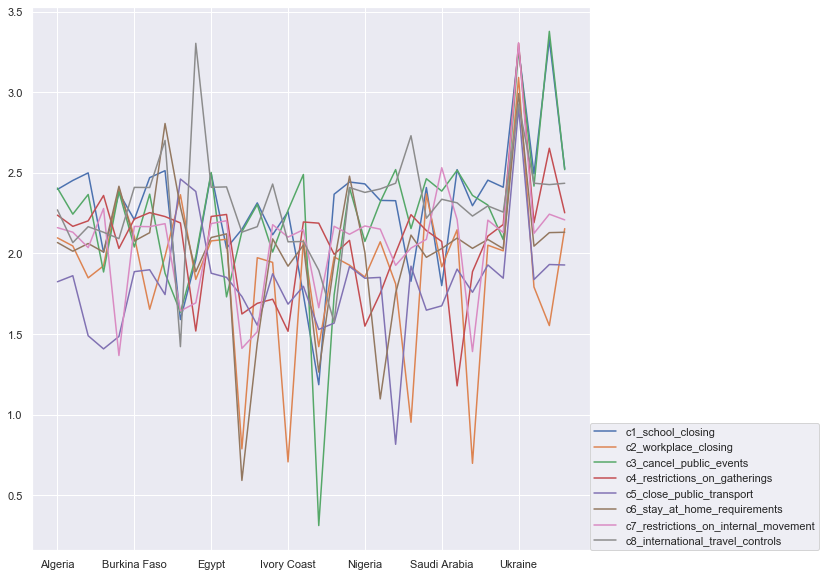

In [506]:
(before_after.unstack().mean(axis=0).sort_values()-before_after.unstack()).apply(lambda x : np.log10(np.abs(x)+1)).plot(figsize=(10,10))
plt.legend(loc=(1.,0.))

In [510]:
before_after.replace(to_replace=0.,value=np.nan).unstack().idxmin(axis=1).value_counts()

c5_close_public_transport               12
c2_workplace_closing                     6
c4_restrictions_on_gatherings            4
c6_stay_at_home_requirements             4
c8_international_travel_controls         3
c3_cancel_public_events                  2
c1_school_closing                        2
c7_restrictions_on_internal_movement     1
dtype: int64

The main issue is the lack of independence, and that the mandates occur first may have a larger share of the effect. Therefore, multiply the residuals by the average time index that each mandate occurs at

In [509]:
tmp = before_minus_after.replace(to_replace=0.,value=np.nan).unstack()
tmp[tmp.idxmin(axis=1)=='c1_school_closing']


,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls
Algeria,0.012912,0.057287,0.014283,0.157101,0.057287,0.057287,0.057287,0.012912
Bosnia And Herzegovina,0.002569,0.017877,0.002888,0.002888,0.017877,0.032491,0.003035,0.002888
Brazil,0.002156,0.002941,0.002156,0.003960,0.010448,0.002941,0.008641,0.002941
Cape Verde,0.051725,0.060247,NaN,0.407806,0.060247,NaN,NaN,NaN
Chad,0.035902,0.035902,0.035902,NaN,0.035902,0.155839,0.035902,NaN
Congo,0.020383,0.020383,0.020383,0.020383,0.101024,0.020383,0.020383,NaN
Cyprus,0.010753,0.034825,NaN,0.124999,0.144817,0.144817,0.144817,0.010753
Democratic Republic Of Congo,0.011694,0.011694,0.011694,0.079945,0.046004,0.290448,0.011786,NaN
Honduras,0.005265,0.007675,0.005265,0.007675,0.007675,0.007675,0.007675,0.007675
Ivory Coast,0.007033,0.007734,0.007734,0.007734,0.029311,0.020729,0.029311,0.007033
